# Multistep VAR Model with all Variables - Monthly Data

In [26]:
# import necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Import Statsmodels
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

Let's test the VAR model with monthly data.

Import the data (I'll first try with monthly data).

In [12]:
dvar = pd.read_csv("../Data/monthly_data.csv")

In [13]:
dvar = dvar.dropna()
dvar.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 94 entries, 1 to 94
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   datetime                 94 non-null     object 
 1   suction_tension (20cm)   94 non-null     float64
 2   suction_tension (40cm)   94 non-null     float64
 3   suction_tension (70cm)   94 non-null     float64
 4   water_temperature        94 non-null     float64
 5   barometric_pressure_qfe  94 non-null     float64
 6   dew_point                94 non-null     float64
 7   water_level              94 non-null     float64
 8   inflow_linth (m3/s)      94 non-null     float64
 9   outflow_limmat (m3/s)    94 non-null     float64
 10  precipitation (mm)       94 non-null     float64
 11  Evapotranspiration (mm)  94 non-null     float64
 12  change_rate              94 non-null     float64
dtypes: float64(12), object(1)
memory usage: 10.3+ KB


In [14]:
# convert DateTime column into datetime format
dvar["datetime"] = pd.to_datetime(dvar['datetime'])
# set DateTime as index
dvar.set_index("datetime", inplace=True)
dvar.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 94 entries, 2012-02-29 to 2019-11-30
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   suction_tension (20cm)   94 non-null     float64
 1   suction_tension (40cm)   94 non-null     float64
 2   suction_tension (70cm)   94 non-null     float64
 3   water_temperature        94 non-null     float64
 4   barometric_pressure_qfe  94 non-null     float64
 5   dew_point                94 non-null     float64
 6   water_level              94 non-null     float64
 7   inflow_linth (m3/s)      94 non-null     float64
 8   outflow_limmat (m3/s)    94 non-null     float64
 9   precipitation (mm)       94 non-null     float64
 10  Evapotranspiration (mm)  94 non-null     float64
 11  change_rate              94 non-null     float64
dtypes: float64(12)
memory usage: 9.5 KB


Visualize the Time Series

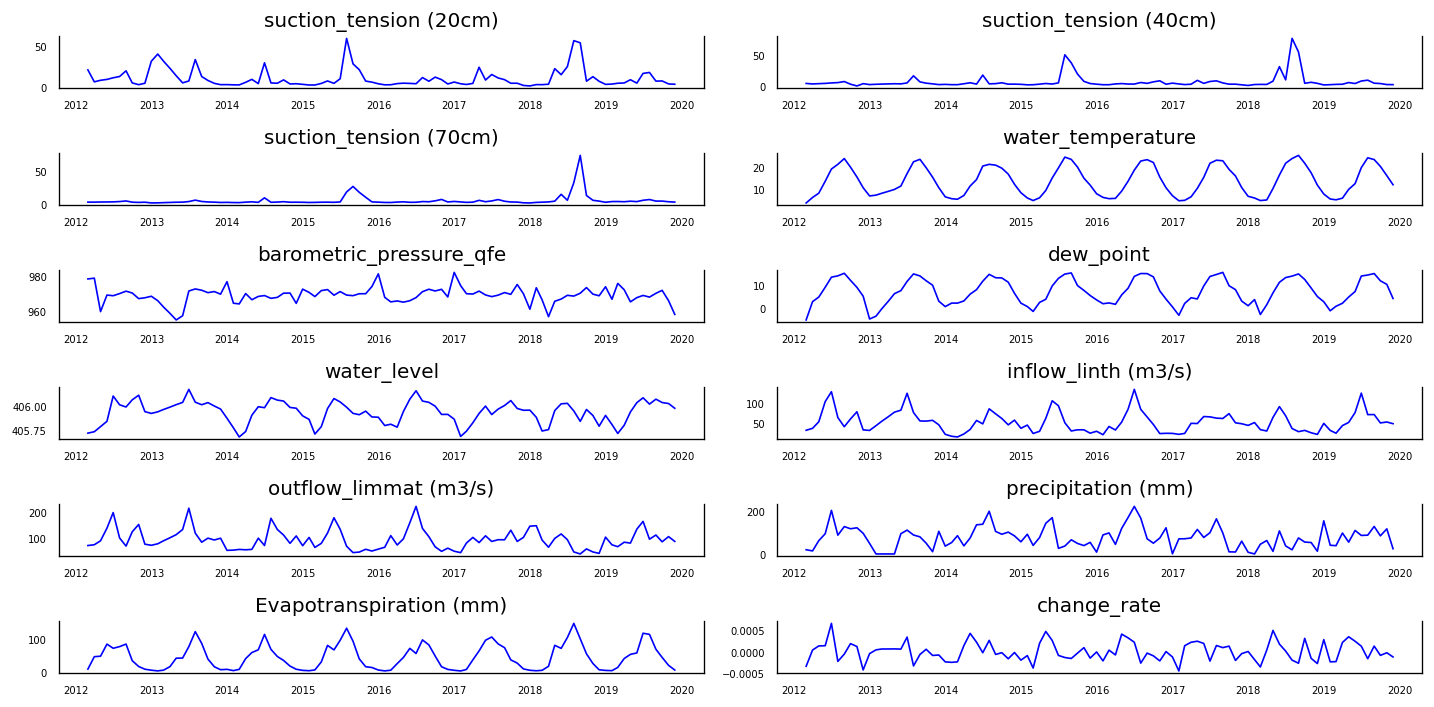

In [15]:
fig, axes = plt.subplots(nrows=6, ncols=2, dpi=120, figsize=(12,6))
for i, ax in enumerate(axes.flatten()):
    data = dvar[dvar.columns[i]]
    ax.plot(data, color='blue', linewidth=1)
    # Decorations
    ax.set_title(dvar.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout()

In [16]:
# drop variable change rate
dvar.drop(columns="change_rate", inplace=True)

As shown in the figure above, there is quite some seasonality.

Check for causality with the Granger test
This test does more check whether one variable explains the other one in terms of forecasting instead of checking for a traditional causality  

In [18]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    
    # The rows are the response variable, columns are predictors. 
    # The values in the table are the P-Values. A P-Value smaller than the significance level (0.05), leads to a rejection of the Null Hypothesis
    # which implies that X "Granger causes" Y.

    dvar = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in dvar.columns:
        for r in dvar.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            dvar.loc[r, c] = min_p_value
    dvar.columns = [var + '_x' for var in variables]
    dvar.index = [var + '_y' for var in variables]
    return dvar

grangers_causation_matrix(dvar, variables = dvar.columns) 

,suction_tension (20cm)_x,suction_tension (40cm)_x,suction_tension (70cm)_x,water_temperature_x,barometric_pressure_qfe_x,dew_point_x,water_level_x,inflow_linth (m3/s)_x,outflow_limmat (m3/s)_x,precipitation (mm)_x,Evapotranspiration (mm)_x
suction_tension (20cm)_y,1.0000,0.3587,0.0335,0.0192,0.0034,0.1014,0.0025,0.0003,0.0054,0.0057,0.0002
suction_tension (40cm)_y,0.0361,1.0000,0.0000,0.0087,0.0182,0.0019,0.0021,0.0037,0.0555,0.0006,0.0000
suction_tension (70cm)_y,0.0000,0.0000,1.0000,0.0216,0.0076,0.0032,0.0238,0.0624,0.4010,0.0081,0.0000
water_temperature_y,0.0035,0.0000,0.0000,1.0000,0.0069,0.0000,0.0002,0.0000,0.0000,0.0033,0.0000
barometric_pressure_qfe_y,0.3970,0.1907,0.1028,0.0010,1.0000,0.0063,0.1748,0.1129,0.3851,0.0364,0.0618
dew_point_y,0.0397,0.1455,0.4942,0.0000,0.0034,1.0000,0.0088,0.0000,0.0034,0.0013,0.0000
water_level_y,0.0154,0.0000,0.0001,0.0000,0.0004,0.0000,1.0000,0.0024,0.0006,0.0177,0.0000
inflow_linth (m3/s)_y,0.0056,0.0000,0.0000,0.0000,0.0003,0.0000,0.0008,1.0000,0.0070,0.0425,0.0000
outflow_limmat (m3/s)_y,0.0331,0.0001,0.0030,0.0004,0.0042,0.0010,0.0196,0.0538,1.0000,0.0050,0.0000
precipitation (mm)_y,0.0042,0.0629,0.0413,0.0000,0.0000,0.0018,0.0039,0.0028,0.0006,1.0000,0.0008


The rows are the Response (Y) and the columns are the predictor series (X).

Cointegration test.

In [19]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(dvar, alpha=0.05): 
    out = coint_johansen(dvar,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(dvar.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(dvar)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
suction_tension (20cm) ::  502.87    > 263.2603  =>   True
suction_tension (40cm) ::  358.64    > 219.4051  =>   True
suction_tension (70cm) ::  262.81    > 179.5199  =>   True
water_temperature ::  183.26    > 143.6691  =>   True
barometric_pressure_qfe ::  113.29    > 111.7797  =>   True
dew_point ::  71.08     > 83.9383   =>   False
water_level ::  40.73     > 60.0627   =>   False
inflow_linth (m3/s) ::  19.32     > 40.1749   =>   False
outflow_limmat (m3/s) ::  6.85      > 24.2761   =>   False
precipitation (mm) ::  1.77      > 12.3212   =>   False
Evapotranspiration (mm) ::  0.21      > 4.1296    =>   False


Order of integration(d) is nothing but the number of differencing required to make a non-stationary time series stationary.

Now, when you have two or more time series, and there exists a linear combination of them that has an order of integration (d) less than that of the individual series, then the collection of series is said to be cointegrated.

Split the data

In [20]:
nobs = 24
dvar_train, dvar_test = dvar[0:-nobs], dvar[-nobs:]

print(dvar_train.shape)  
print(dvar_test.shape)

(70, 11)
(24, 11)


Stationarity.
For the VAR Model only stationary time series can be used. In order to verify it, we are going to use the ADF test.

In [21]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.") 

In [22]:
for name, column in dvar_train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "suction_tension (20cm)" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.1883
 No. Lags Chosen       = 0
 Critical value 1%     = -3.529
 Critical value 5%     = -2.904
 Critical value 10%    = -2.59
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "suction_tension (40cm)" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -4.4938
 No. Lags Chosen       = 0
 Critical value 1%     = -3.529
 Critical value 5%     = -2.904
 Critical value 10%    = -2.59
 => P-Value = 0.0002. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "suction_tension (70cm)" 
    -----------------------------------------------
 Null Hypothesis: Data has un

C:\Users\lucal\AppData\Local\Temp\ipykernel_30132\1179845333.py:1: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, column in dvar_train.iteritems():


All except water level are stationary. We need to difference the variables and then check the ADF one more time.

In [23]:
# difference the training data once
dvar_differenced = dvar_train.diff().dropna()

In [24]:
# check again with the ADF test whether all series are now stationary
for name, column in dvar_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "suction_tension (20cm)" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -10.6765
 No. Lags Chosen       = 0
 Critical value 1%     = -3.53
 Critical value 5%     = -2.905
 Critical value 10%    = -2.59
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "suction_tension (40cm)" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -7.3255
 No. Lags Chosen       = 1
 Critical value 1%     = -3.532
 Critical value 5%     = -2.906
 Critical value 10%    = -2.59
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "suction_tension (70cm)" 
    -----------------------------------------------
 Null Hypothesis: Data has unit 

C:\Users\lucal\AppData\Local\Temp\ipykernel_30132\3428697774.py:1: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, column in dvar_differenced.iteritems():


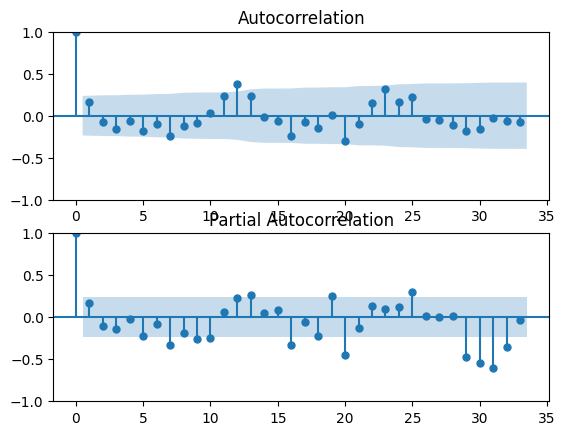

In [29]:
# plot autocorrelation and partial autocorrelation
fig, ax = plt.subplots(2,1)
fig = sm.graphics.tsa.plot_acf(dvar_differenced["water_level"], lags=33, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(dvar_differenced["water_level"], lags=33, ax=ax[1])
plt.show()

# it seems like the lags for the partial autocorrelation are mostly insignificant which means that in combination with the ADF test (p-calue < 0.05) that the water level series
# is now also stationary

Selection of the p order for the VAR.

In [40]:
model = VAR(dvar_differenced)

maxlags = 4

print(model.select_order(maxlags))
print(model.fit(maxlags=maxlags, ic='aic').summary())

c:\Users\lucal\miniconda3\envs\dsf\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


<statsmodels.tsa.vector_ar.var_model.LagOrderResults object. Selected orders are: AIC -> 4, BIC -> 0, FPE -> 4, HQIC ->  4>
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 29, Nov, 2022
Time:                     21:34:15
--------------------------------------------------------------------
No. of Equations:         11.0000    BIC:                    38.7219
Nobs:                     65.0000    HQIC:                   28.6966
Log likelihood:          -1239.84    FPE:                1.42782e+11
AIC:                      22.1631    Det(Omega_mle):     4.37928e+08
--------------------------------------------------------------------
Results for equation suction_tension (20cm)
                                coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------------
const                             -0.490733         1.3

In [44]:
# instantiate model with the differenced data
model = VAR(dvar_differenced)
# check different performance measures for a range of lags to see which one performs best 
# everything from lag 5 onwards causes an error so we only include lags up until 4
for i in [1,2,3,4]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  30.74164771630987
BIC :  35.05010384988702
FPE :  23375723873158.332
HQIC:  32.44878998715174 

Lag Order = 2
AIC :  30.080472559473645
BIC :  38.40565513717386
FPE :  15943210077221.398
HQIC:  33.374768128273544 

Lag Order = 3
AIC :  28.196899006480756
BIC :  40.604942544630504
FPE :  5849298106736.231
HQIC:  33.09990674725053 

Lag Order = 4
AIC :  22.163128427287397
BIC :  38.72192379033878
FPE :  142782482982.9397
HQIC:  28.6966347345538 



c:\Users\lucal\miniconda3\envs\dsf\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


Let's try lag 3.

Train the model with the lag 3.

In [82]:
model_fitted = model.fit(4)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 29, Nov, 2022
Time:                     21:49:38
--------------------------------------------------------------------
No. of Equations:         11.0000    BIC:                    38.7219
Nobs:                     65.0000    HQIC:                   28.6966
Log likelihood:          -1239.84    FPE:                1.42782e+11
AIC:                      22.1631    Det(Omega_mle):     4.37928e+08
--------------------------------------------------------------------
Results for equation suction_tension (20cm)
                                coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------------
const                             -0.490733         1.314969           -0.373           0.709
L1.suction_tension (20cm)         -1.093976         0.549904           -1.989        

Residuals with Durbin Watson Statistic

In [73]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)

for col, val in zip(dvar.columns, out):
    print(col, ':', round(val, 2))

suction_tension (20cm) : 2.13
suction_tension (40cm) : 2.29
suction_tension (70cm) : 2.25
water_temperature : 2.24
barometric_pressure_qfe : 1.94
dew_point : 1.47
water_level : 2.12
inflow_linth (m3/s) : 2.22
outflow_limmat (m3/s) : 2.17
precipitation (mm) : 1.5
Evapotranspiration (mm) : 2.29


CHECK THE MEANING

Forecasting

In [74]:
lag_order = model_fitted.k_ar
print(lag_order)  

# Input data for forecasting
forecast_input = dvar_differenced.values[-lag_order:]
forecast_input

4


array([[-2.09583333e+00, -3.34194483e+00, -2.54197873e+00,
        -2.62065607e-01,  1.43534946e+00,  9.33955509e-01,
         3.78090034e-02, -9.43165568e-01, -3.30458789e-01,
        -6.63000000e+01, -1.16100000e+01],
       [-4.46136050e+00, -1.98757469e+00, -1.13229370e+00,
        -3.85195242e+00, -9.86246147e-01, -5.93136725e+00,
         5.19411462e-02,  1.20421377e+01,  3.69906792e+01,
        -8.80000000e+01, -3.76500000e+01],
       [ 2.28649912e-02, -6.62040338e-03, -1.29874483e-01,
        -2.98199683e+00,  5.49132470e+00, -1.73545980e+00,
        -8.33471405e-02, -2.27897524e+01, -4.33291147e+01,
        -7.00000000e-01, -9.96000000e+00],
       [-2.73175662e+00, -1.05441048e+00, -1.06034517e+00,
        -5.20708647e+00, -5.16991541e+00, -5.08467213e+00,
        -1.88699181e-02, -2.25980943e+00,  1.55981739e+01,
         5.06000000e+01, -1.79500000e+01]])

In [75]:
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
dvar_forecast = pd.DataFrame(fc, index=dvar.index[-nobs:], columns=dvar.columns + '_1d')
dvar_forecast

,suction_tension (20cm)_1d,suction_tension (40cm)_1d,suction_tension (70cm)_1d,water_temperature_1d,barometric_pressure_qfe_1d,dew_point_1d,water_level_1d,inflow_linth (m3/s)_1d,outflow_limmat (m3/s)_1d,precipitation (mm)_1d,Evapotranspiration (mm)_1d
datetime,,,,,,,,,,,
2017-12-31,-2.252578,-5.883316,-1.140775,-3.327422,-5.910465,-1.391860,-0.055521,-0.881254,-9.156747,43.651322,-21.948888
2018-01-31,-4.727402,-7.865407,-4.984465,-1.449956,5.343777,0.425897,0.061916,33.349676,60.641092,-44.685649,4.780611
2018-02-28,15.788475,10.592991,1.806990,2.011359,-4.183570,-0.513179,-0.016180,5.103235,-2.367517,-32.045967,34.078201
2018-03-31,-7.655674,0.505116,2.112381,3.309036,-0.583700,5.680848,-0.002557,-9.121187,-16.825559,-5.719173,19.328777
2018-04-30,-0.985826,2.282950,2.155030,2.892819,-0.922944,2.206269,0.011817,-8.539506,-29.994767,39.578779,23.148303
2018-05-31,1.991599,1.102064,1.292022,3.102288,-4.210397,2.825084,0.143815,32.793230,62.903549,110.094742,-2.094843
2018-06-30,-10.083084,-7.778955,-3.514806,3.149958,6.849080,3.095031,0.081856,25.195032,43.785544,-36.211136,7.872756
2018-07-31,17.416466,10.650799,1.608184,2.861354,5.415043,-0.307420,-0.036363,-18.816197,-41.618556,-60.995265,17.873713
2018-08-31,-4.763982,0.724840,2.288748,-0.211073,-0.820670,-0.741325,-0.084748,-39.325687,-56.902125,-13.491941,-17.402171


In [76]:
# function for inverting the differenced data
def invert_transformation(dvar_train, dvar_forecast, first_diff=False): 
    dvar_fc = dvar_forecast.copy()
    columns = dvar_train.columns
    for col in columns:        
        dvar_fc[str(col)+'_forecast'] = dvar_train[col].iloc[-1] + dvar_fc[str(col)+'_1d'].cumsum()
    return dvar_fc

In [77]:
dvar_results = invert_transformation(dvar_train, dvar_forecast, first_diff=True)        
dvar_results.loc[:, ['suction_tension (20cm)_forecast', 'suction_tension (40cm)_forecast', 'suction_tension (70cm)_forecast', 'water_temperature_forecast', 'barometric_pressure_qfe_forecast',
                   'dew_point_forecast', 'water_level_forecast', 'inflow_linth (m3/s)_forecast', 'outflow_limmat (m3/s)_forecast', 'precipitation (mm)_forecast', 'Evapotranspiration (mm)_forecast']]

,suction_tension (20cm)_forecast,suction_tension (40cm)_forecast,suction_tension (70cm)_forecast,water_temperature_forecast,barometric_pressure_qfe_forecast,dew_point_forecast,water_level_forecast,inflow_linth (m3/s)_forecast,outflow_limmat (m3/s)_forecast,precipitation (mm)_forecast,Evapotranspiration (mm)_forecast
datetime,,,,,,,,,,,
2017-12-31,-0.583717,-3.943289,0.194464,7.369114,963.936047,1.492061,405.899673,48.094992,93.629241,103.451322,-13.818888
2018-01-31,-5.311120,-11.808695,-4.790001,5.919158,969.279824,1.917958,405.961589,81.444668,154.270333,58.765672,-9.038277
2018-02-28,10.477356,-1.215704,-2.983011,7.930516,965.096254,1.404779,405.945409,86.547903,151.902816,26.719705,25.039924
2018-03-31,2.821682,-0.710589,-0.870630,11.239553,964.512554,7.085627,405.942852,77.426716,135.077257,21.000532,44.368701
2018-04-30,1.835856,1.572361,1.284400,14.132371,963.589610,9.291896,405.954670,68.887211,105.082490,60.579311,67.517004
2018-05-31,3.827455,2.674425,2.576421,17.234660,959.379213,12.116980,406.098485,101.680441,167.986039,170.674053,65.422161
2018-06-30,-6.255630,-5.104530,-0.938385,20.384617,966.228292,15.212011,406.180341,126.875473,211.771582,134.462918,73.294917
2018-07-31,11.160836,5.546269,0.669799,23.245971,971.643335,14.904591,406.143978,108.059276,170.153026,73.467653,91.168630
2018-08-31,6.396854,6.271109,2.958547,23.034899,970.822665,14.163266,406.059230,68.733588,113.250901,59.975712,73.766459


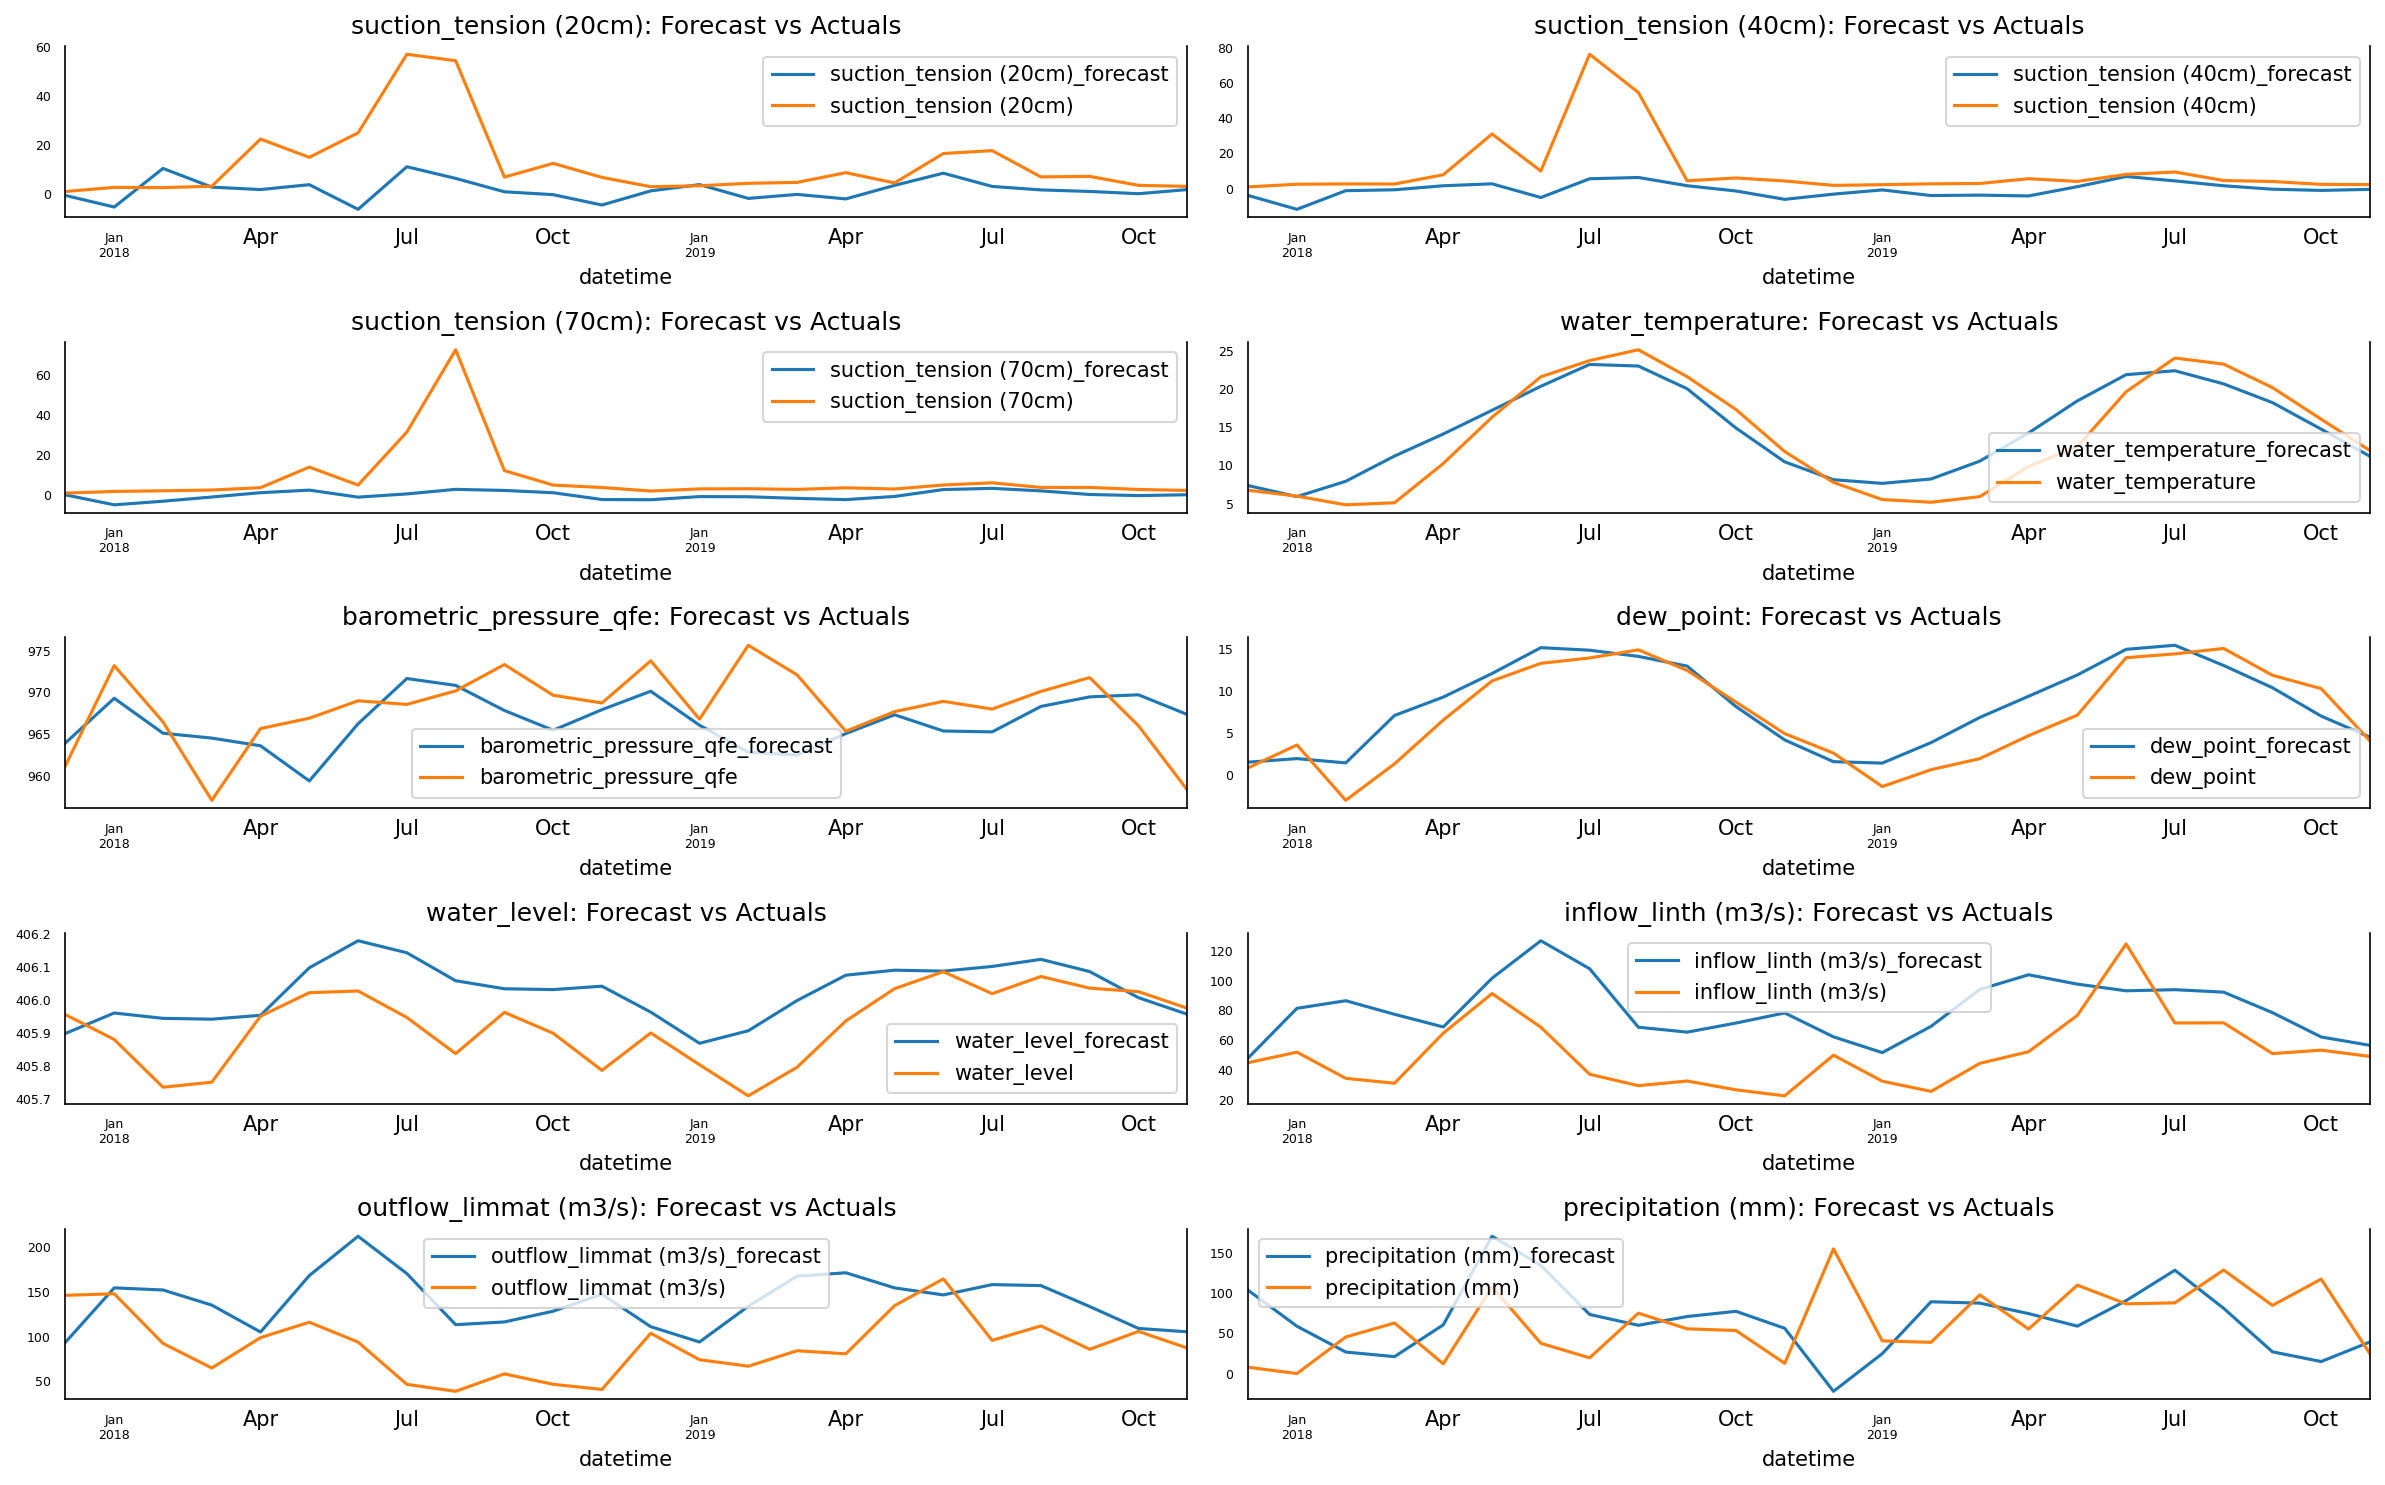

In [78]:
fig, axes = plt.subplots(nrows=int(len(dvar.columns)/2), ncols=2, dpi=150, figsize=(16,10))
for i, (col,ax) in enumerate(zip(dvar.columns, axes.flatten())):
    dvar_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    dvar_test[col][-nobs:].plot(legend=True, ax=ax)
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout()


<AxesSubplot: xlabel='datetime'>

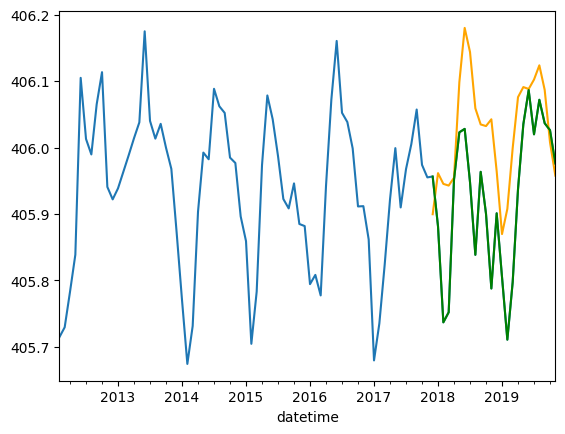

In [79]:
import matplotlib.pyplot as plt
dvar["water_level"].plot()
dvar_results["water_level_forecast"].plot(color="orange")
dvar_test["water_level"].plot(color="green")

In [80]:
from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})

print('Forecast Accuracy of: water_level')
accuracy_prod = forecast_accuracy(dvar_results['water_level_forecast'].values, dvar_test['water_level'])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))


Forecast Accuracy of: water_level
mape :  0.0003
me :  0.1
mae :  0.1077
mpe :  0.0002
rmse :  0.1316
corr :  0.6359
minmax :  0.0003


C:\Users\lucal\AppData\Local\Temp\ipykernel_30132\522686556.py:10: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)
C:\Users\lucal\AppData\Local\Temp\ipykernel_30132\522686556.py:12: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)


In [ ]:
nobs 24

lag=4
mape :  0.0003
me :  0.1
mae :  0.1077
mpe :  0.0002
rmse :  0.1316
corr :  0.6359
minmax :  0.0003

lag=3
mape :  0.0002
me :  0.0543
mae :  0.0727
mpe :  0.0001
rmse :  0.0982
corr :  0.69
minmax :  0.0002

lag=2
mape :  0.0002
me :  0.0347
mae :  0.0836
mpe :  0.0001
rmse :  0.1062
corr :  0.4547
minmax :  0.0002


